In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys
from pynverse import inversefunc

from intersect import intersection


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"

# **Plot PRC and period mismatched periodic pulse-train**

In [2]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.01
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
#aln.params['Ke_gl'] = 30.
prc = PRC_ALN(aln)

INFO:root:aln: Model initialized.
ic| domfreq: 21.50526315789473


initialised ...


In [4]:
prc_xcorr = np.load('data/PRC_0,2mV5ms.npy',allow_pickle='TRUE').item()

In [5]:
def lambda_factory(ab):
    return lambda x:x*ab[0]+ab[1]

def broken_line(x, x0, y0):
    cl = []
    fl = []
    for i in range(len(x0)-1):
        ab = np.polyfit(x0[i:i+2], y0[i:i+2], 1)
        #ic(ab)
        # Compute and append a "condition" interval
        cl.append(np.logical_and(x >= x0[i], x <= x0[i+1]))
        # Create a line function for the interval
        fl.append(lambda_factory(ab))
    return(np.piecewise(x, condlist=cl, funclist=fl))


def f1(x):
    return broken_line(x, x1, y1)

def f2(x):
    return broken_line(x, x2[::-1], y2[::-1])

def f(xy):
    x, y = xy
    z = np.array([y - f1(x), y - f2(x)])
    return z

In [6]:
period_fr = prc.frperiod
phis = np.asarray(list(prc_xcorr.keys()))
prcs = np.asarray(list(prc_xcorr.values()))

# Have a data point for phi=0 and phi=T
#phis = np.concatenate(([0.], phis))
#phis = np.concatenate((phis, [period_fr]))
#prcs = np.concatenate(([prcs[0]], prcs))
#prcs = np.concatenate((prcs, [prcs[-1]]))
def prc_func(x):
    return broken_line(x, phis, prcs) 

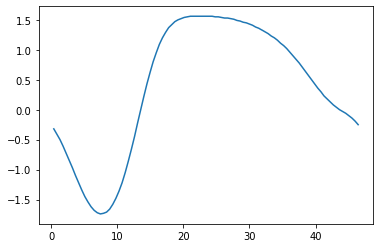

In [7]:
plt.plot(phis, prcs)

## get simulation results

In [8]:
def evalf():
    pass

period_mismatch = np.arange(-3, 3, 0.1)
stim_amplitude = [0.2]
stim_width = [5]
parameters = ParameterSpace({"period_mismatch": period_mismatch,
                             "stim_amplitude": stim_amplitude,
                             "stim_width": stim_width
                             })

search = BoxSearch(evalFunction = evalf,
                   parameterSpace=parameters,
                   filename=HDF_PATH+'Entrainment_0.2mV5ms_test2.hdf')

INFO:root:Number of processes: 4
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/Entrainment_0.2mV5ms_test2.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 60
MainProcess root INFO     BoxSearch: Environment initialized.


In [9]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/Entrainment_0.2mV5ms_test2.hdf
MainProcess root INFO     Analyzing trajectory results-2021-09-05-11H-47M-34S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/Entrainment_0.2mV5ms_test2.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2021-09-05-11H-47M-34S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 60/60 [00:00<00:00, 82.02it/s]
MainProcess root INFO     All results loaded.


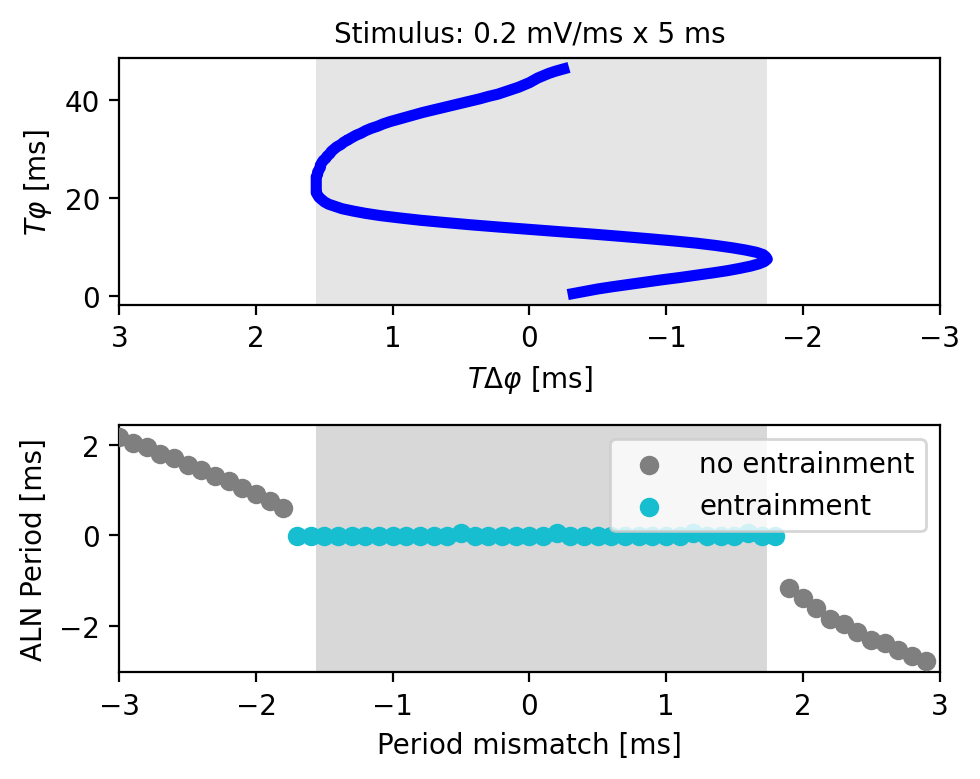

In [10]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
fig, axs = plt.subplots(2,1, figsize=(5,4), dpi=200)
#plt.suptitle("Frequency entrainment: prediction and experiment", y=1.05)
#ax2 = ax.twinx()
#ax.plot(stim_response.keys(), stim_response.values(), color=colrs[6], lw=3)
axs[0].axvspan(min(prcs), max(prcs), facecolor='grey', alpha=0.2)
axs[0].plot(prcs, phis, lw=4, color="b", label="PRC")
axs[0].set_xlabel(r"$T \Delta \varphi$ [ms]")
axs[0].set_ylabel(r"$T \varphi$ [ms]")
axs[0].set_xlim(3,-3)
for i in search.dfResults.index:
    if search.dfResults['entrainment'][i]:
        axs[1].scatter(search.dfResults['period_mismatch'][i], (1000 / search.dfResults['dom_freq'][i]) - (1000 / search.dfResults['stim_freq'][i]), color=colrs[5], label="entrainment", zorder=5)
    else:
        axs[1].scatter(search.dfResults['period_mismatch'][i], (1000 / search.dfResults['dom_freq'][i]) - (1000 / search.dfResults['stim_freq'][i]), color=colrs[0], label="no entrainment", zorder=5)

axs[1].axvspan(-min(prcs), -max(prcs), facecolor='grey', alpha=0.3)
axs[1].set_ylabel("ALN Period [ms]")
axs[1].set_xlabel("Period mismatch [ms]")
axs[1].set_xlim(-3,3)
axs[0].set_title("Stimulus: 0.2 mV/ms x 5 ms", size=10)

legend_without_duplicate_labels(axs[1])
fig.tight_layout()

## now with my style

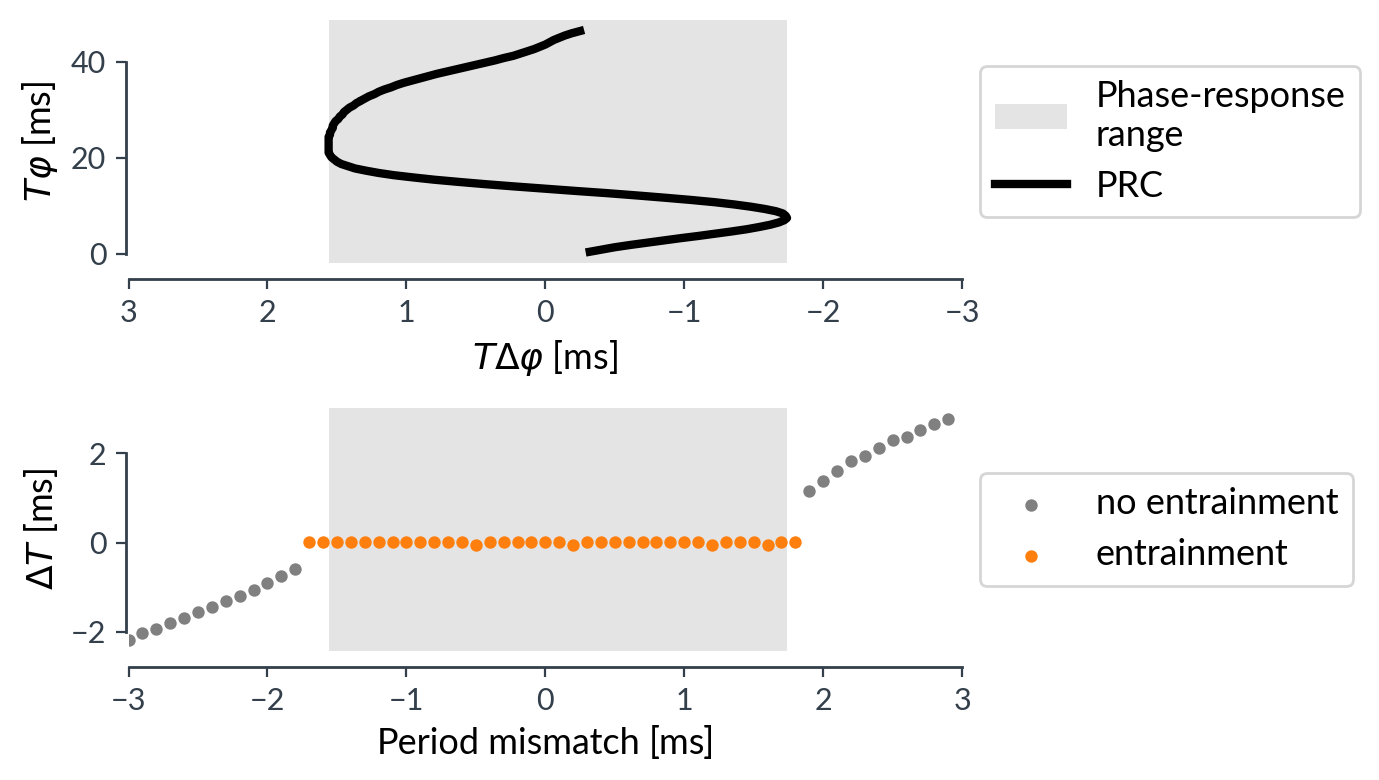

In [11]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(1, 0.5))
fig, axs = plt.subplots(2,1, figsize=(7,4), dpi=200)

#plt.suptitle("Frequency entrainment: prediction and experiment", y=1.05)
#ax2 = ax.twinx()
#ax.plot(stim_response.keys(), stim_response.values(), color=colrs[6], lw=3)
axs[0].axvspan(min(prcs), max(prcs), facecolor='lightgrey', alpha=0.6, label="Phase-response\nrange")
axs[0].plot(prcs, phis, lw=3, color="black", label="PRC")
axs[0].set_xlabel(r"$T \Delta \varphi$ [ms]")
axs[0].set_ylabel(r"$T \varphi$ [ms]")
axs[0].set_xlim(3,-3)
for i in search.dfResults.index:
    if search.dfResults['entrainment'][i]:
        axs[1].scatter(search.dfResults['period_mismatch'][i], (1000 / search.dfResults['stim_freq'][i]) - (1000 / search.dfResults['dom_freq'][i]) , color="tab:orange", label="entrainment", s=12,  zorder=5)
    else:
        axs[1].scatter(search.dfResults['period_mismatch'][i], (1000 / search.dfResults['stim_freq'][i]) - (1000 / search.dfResults['dom_freq'][i]) , color="grey", label="no entrainment", s=12, zorder=5)

axs[1].axvspan(-min(prcs), -max(prcs), facecolor='lightgrey', alpha=0.6)
ax0tr = axs[0].transData # Axis 0 -> Display
ax1tr = axs[1].transData # Axis 1 -> Display
figtr = fig.transFigure.inverted() # Display -> Figure

xy = figtr.transform(ax1tr.transform((-max(prcs), -2.45)))

box = matplotlib.patches.Rectangle(
    xy, .448,.805, transform=fig.transFigure, color="lightgrey", alpha=0.6, zorder=0
)

#fig.patches.append(box)
coord1 = figtr.transform(ax0tr.transform((0, 0)))
coord2 = figtr.transform(ax1tr.transform((0, 0)))
line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                               transform=fig.transFigure)
#fig.lines = line,


axs[1].set_ylabel(r"$\Delta T$ [ms]")
axs[1].set_xlabel("Period mismatch [ms]")
axs[1].set_xlim(-3,3)
#axs[0].set_title("Stimulus: 0.2 mV/ms x 5 ms", size=10)
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

legend_without_duplicate_labels(axs[1])
axs[0].tick_params(right=False, top=False)
axs[1].tick_params(right=False, top=False)

axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)
#ax.spines["bottom"].set_bounds(low=0, high=100)
plt.draw()
lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')][1:-1]
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", 6))

lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_xticklabels(which='both')]
axs[0].spines["bottom"].set_bounds(low=min(lab), high=max(lab))

lab = [float(item.get_text().replace("−", "-")) for item in axs[1].get_yticklabels(which='both')][1:-1]
axs[1].spines["left"].set_bounds(low=min(lab), high=max(lab))

lab = [float(item.get_text().replace("−", "-")) for item in axs[1].get_xticklabels(which='both')]
axs[1].spines["bottom"].set_bounds(low=min(lab), high=max(lab))

for line in ["bottom"]:
    axs[0].spines[line].set_linewidth(1)
    axs[0].spines[line].set_position(("outward",6))
    axs[1].spines[line].set_linewidth(1)
    axs[1].spines[line].set_position(("outward",6))
for line in ["left"]:
    axs[0].spines[line].set_linewidth(1)
    axs[0].spines[line].set_position(("outward",1))
    axs[1].spines[line].set_linewidth(1)
    axs[1].spines[line].set_position(("outward",1))

fig.tight_layout()

#fig.savefig("Pics/Entrainment_Region.pdf")